In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold,KFold,train_test_split
from scipy.stats import randint, uniform
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import LabelKFold
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score

%matplotlib inline
import matplotlib.pyplot as plt

import datetime
import random
from operator import itemgetter
import time
import copy

from scipy.io import mmread

np.random.seed(333)

In [2]:
dtrain = (mmread('writemm_sparse/dtrain_sparse')).tocsr()
dtest = (mmread('writemm_sparse/dtest_sparse')).tocsr()

act_train_data = pd.read_csv("redhat_data_new/act_train_new_try2.csv",dtype={'people_id': np.str, 'activity_id': np.str, 'outcome': np.int8}, parse_dates=['date'])
act_test_data  = pd.read_csv("redhat_data_new/act_test_new_try2.csv", dtype={'people_id': np.str, 'activity_id': np.str}, parse_dates=['date'])
people_data    = pd.read_csv("redhat_data_new/people.csv", dtype={'people_id': np.str, 'activity_id': np.str, 'char_38': np.int32}, parse_dates=['date'])

In [3]:
act_test_data['outcome'] = pd.Series([0.5]*(act_test_data.shape[0]))
train_data = pd.concat([act_train_data, act_test_data], ignore_index=True)
print('All features: train_data shape {}'.format(train_data.shape))

All features: train_data shape (2695978, 15)


In [4]:
from scipy.sparse import csr_matrix, hstack, vstack
Xtrain = vstack((dtrain, dtest), format='csr')
print('All features: train shape {}'.format(Xtrain.shape))

All features: train shape (2695978, 14140)


In [5]:
y1 = [0]*(dtrain.shape[0])
y2 = [1]*(dtest.shape[0])
y = pd.Series(y1 + y2)
from sklearn.preprocessing import LabelEncoder
targetencoder = LabelEncoder().fit(y.values)
y = targetencoder.transform(y.values)
nclasses = len(targetencoder.classes_)

In [6]:
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
Xtrain = max_abs_scaler.fit_transform(Xtrain)

In [7]:
lkf = LabelKFold(train_data['people_id'], n_folds=20)
def score(clf, random_state = 444):
    #lkf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in lkf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        print("{:.5f}".format(roc_auc_score(yte, pred[itest,1:])), end=' ')
        #return roc_auc_score(yte, pred[itest, 1:])
    
    print("score : {:.5f}".format(roc_auc_score(y, pred[:,1:])), end=' ')
    return pred

In [ ]:
##5 fold results

##[  8.51138038   9.40444852  10.39122304  11.48153621  12.68625198
  #14.01737418  15.48816619  17.11328304  18.90891748  20.89296131]
#0.91325 0.90810 0.89498 score : 0.89633 0.91715 0.86580 0.91293 0.91057 0.89597 score : 0.90004 
#0.91534 0.84096 0.91374 0.91210 0.89708 score : 0.89599 0.91525 0.84825 0.91396 0.91092 0.89568 score : 0.89617 
#0.91668 0.85230 0.91322 0.90786 0.89622 score : 0.89677 0.91644 0.84377 0.91517

#0.91715 0.86580 0.91293 0.91057 0.89597 score : 0.90004 
#

In [8]:
preds = score(LogisticRegression(C=9.40444852, class_weight='balanced', solver='lbfgs', n_jobs=-1))

0.95235 0.71401 0.94864 0.92181 0.93047 0.89489 0.86900 0.91507 0.91840 0.89552 0.90342 0.87969 0.87038 0.93145 0.92415 0.93080 0.91697 0.91960 0.91482 0.89661 score : 0.90112 

In [12]:
df1 = pd.DataFrame(preds)

In [14]:
df1.columns = ['prob0','prob1']

In [15]:
df1.head()

,prob0,prob1
0,1.0,5.994453e-32
1,1.0,6.036656e-32
2,1.0,6.036656e-32
3,1.0,6.036656e-32
4,1.0,6.036656e-32


In [19]:
df1[df1.prob1>0.8].shape

(334945, 2)

In [21]:
train_data['prob1'] = df1['prob1']

In [42]:
tr_range = np.arange(0,act_train_data.shape[0],1)
te_range = np.arange(act_train_data.shape[0],train_data.shape[0],1)
act_train_data_new = train_data.ix[tr_range]
act_test_data_new = train_data.ix[te_range]

In [46]:
act_test_data_new.head(2)

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,prob1
2613823,ppl_100179,act2_2277070,2022-09-02,type 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 23,0.5,0.703548
2613824,ppl_100179,act2_3152044,2022-09-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.5,0.764599


In [47]:
act_train_data_new.to_csv('act_train_new_with_probs.csv',index=False)
act_test_data_new.to_csv('act_test_new_with_probs.csv',index=False)

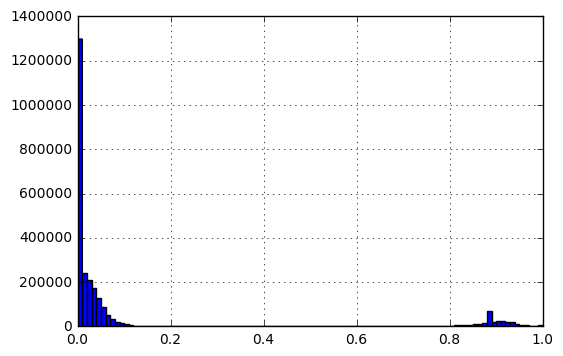

In [50]:
act_train_data_new.prob1.hist(bins=100)

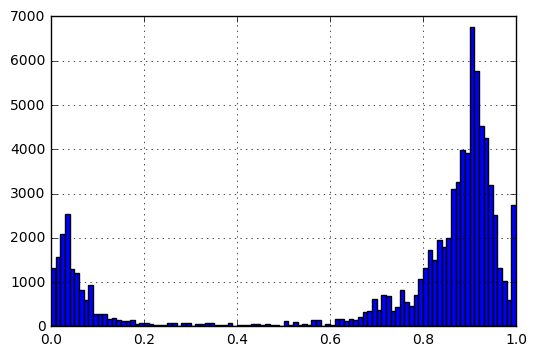

In [51]:
act_test_data_new.prob1.hist(bins=100)

In [168]:
aa = act_train_data_new[act_train_data_new.prob1>0.9]
ab = act_train_data_new[act_train_data_new.prob1<=0.9]

In [169]:
aa.outcome.value_counts()

0.0    70299
1.0    54092
Name: outcome, dtype: int64

In [170]:
ab.outcome.value_counts()

0.0    1358473
1.0    1130959
Name: outcome, dtype: int64

In [171]:
c = list(set(aa.people_id.unique())&set(ab.people_id.unique()))

In [172]:
len(c)

3502

In [173]:
len(set(aa.people_id.unique()))

10344

In [174]:
aa.shape

(124391, 16)

In [175]:
ac = ab.loc[ab['people_id'].isin(c)]
ad = ab.loc[~ab['people_id'].isin(c)]
ac.shape,ad.shape

((37535, 16), (2451897, 16))

In [176]:
ac.outcome.value_counts()

0.0    23173
1.0    14362
Name: outcome, dtype: int64

In [177]:
ae = aa.append(ac, ignore_index=True)
ae.shape

(161926, 16)

In [178]:
ae.outcome.sum()/ae.shape[0]

0.4227486629695046

In [179]:
ad.outcome.sum()/ad.shape[0]

0.4554012668558263

In [181]:
list(set(ad.people_id.unique())&set(ae.people_id.unique()))

[]

In [183]:
ae.shape,ad.shape

((161926, 16), (2451897, 16))

In [201]:
ad.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,prob1
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0.0,5.994453e-32
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0,6.036656e-32
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0,6.036656e-32
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0,6.036656e-32
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0,6.036656e-32


In [196]:
ae.sort_values(by='people_id',inplace=True)
ad.sort_values(by='people_id',inplace=True)

/home/choudharyk0408/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [198]:
ad.to_csv('act_train_row_engineering_2451897.csv',index=False)
ae.to_csv('act_test_row_engineering_161926.csv',index=False)

In [204]:
ad.drop(['prob1'],axis=1,inplace=True)
ad.to_csv('train1.csv', index=False)
af = ae[['activity_id','outcome']]
af.to_csv('val1_target.csv', index=False)
ae.drop(['outcome','prob1'],axis=1,inplace=True)
ae.to_csv('val1.csv', index=False)

/home/choudharyk0408/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [208]:
af.shape,ae.shape,ad.shape,act_train_data.shape,act_test_data.shape

((161926, 2), (161926, 14), (2451897, 15), (2613823, 15), (82155, 15))